In [1]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Mounted at /content/drive


In [3]:
# GMMの変分推論版で使うライブラリ
from scipy.stats import multivariate_normal # 多次元ガウス分布
from scipy.special import psi # ディガンマ関数

# GMMのパラメータの変分推論による推定

教科書 4.4.3節を参考に、人工的に生成したデータを用いて、GMMのパラメータを変分推論により推定します。

コード元：https://www.anarchive-beta.com/entry/2020/12/15/114837

## 真のモデルのパラメータとモデルから生成した観測データををJSONから読み込み

In [4]:
# note12-1で保存したパラメータを利用する
import json
with open(output_dir + 'note12-1_output.json') as json_file:
   json_data = json.load(json_file) # JSONファイルを辞書型の変数として読み出す

#print (json_data)

# 個別の変数に戻す
D = json_data['D'] # 次元数:(固定)
K = json_data['K'] # クラスタ数
N = json_data['N']

# ndarray 型に戻し、行列などに reshape で戻す
# 真のモデル関連
mu_truth_kd = np.array(json_data['mu_truth_kd']) # K個の真の平均を指定
sigma2_truth_kdd = np.array(json_data['sigma2_truth_kdd']).reshape(K,D,D) # K個の真の共分散行列を指定
pi_truth_k = np.array(json_data['pi_truth_k']) # 真の混合比率を指定（各値は0以上で、合計は1になること）
# 真のモデルから生成した観測データ関連
s_truth_nk = np.array(json_data['s_truth_nk']).reshape(N,K) # 潜在変数
s_truth_n = np.array(json_data['s_truth_n']).reshape(N,) # クラスタ番号
x_nd = np.array(json_data['x_nd']).reshape(N,D) # ランダムサンプリングより得た観測データ

# 作図データを作成作成
# 作図用のx軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_1_line = np.linspace(
    np.min(mu_truth_kd[:, 0] - 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    np.max(mu_truth_kd[:, 0] + 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    num=300
)

# 作図用のy軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_2_line = np.linspace(
    np.min(mu_truth_kd[:, 1] - 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    np.max(mu_truth_kd[:, 1] + 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    num=300
)

# 確率密度を等高線図にする際に格子状の点(2軸の全ての値が直交する点)を渡す必要があるため、作図用の格子状の点を作成する。する。
# x_1_lineとx_2_lineの要素の全ての組み合わせを持つような2次元配列に変換している。
x_1_grid, x_2_grid = np.meshgrid(x_1_line, x_2_line)

# x_1_grid, x_2_gridの要素を列として持つ2次元配列を作成をし、作図用のxの点とする。
x_point = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存：
# 計算結果の確率密度は1次元配列になり、作図時にx_1_grid, x_2_gridと同じ形状にする必要があるため、形状をx_dimとして保存
x_dim = x_1_grid.shape

# 観測モデルの確率密度を計算しなおしておく
# K個のパラメータmu_truth_kd, sigmga2_truth_ddkを使って、x_point_matの点ごとに、次の混合ガウス分布の式で確率密度を計算
true_model = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(x=x_point, mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k])
    
    # K個の分布の加重平均を計算
    true_model += pi_truth_k[k] * tmp_density

# 確認
print(true_model[:5])


[9.06768334e-13 1.07345258e-12 1.27033352e-12 1.50260830e-12
 1.77630256e-12]


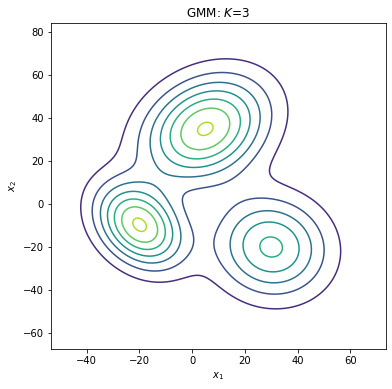

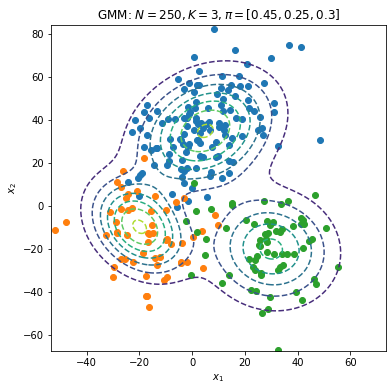

In [5]:
# 観測モデルを作図
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim)) # 真の分布
plt.title('GMM: $K$=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

# モデルに観測データの散布図を重ねて表示
plt.figure(figsize=(6, 6))
for k in range(K):
    k_idx, = np.where(s_truth_n == k) # クラスタkのデータのインデック
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # 観測データ
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), linestyles='--') # 真の分布
plt.title('GMM: $N=' + str(N) + ', K=' + str(K) + 
          ', \pi=[' + ', '.join([str(pi) for pi in pi_truth_k]) + ']$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## 観測データから各データのクラスタを推定

### 事前分布を設定

次に、観測モデル(観測データの分布)と潜在変数の分布に対する共役事前分布を設定します。多次元ガウス分布のパラメータに対する事前分布としてガウス・ウィシャート分布、カテゴリ分布のパラメータ
に対する事前分布としてディリクレ分布
を設定します。

(300, 300)
[1.10780663e-05 1.12959859e-05 1.15165400e-05 1.17397162e-05
 1.19655008e-05]


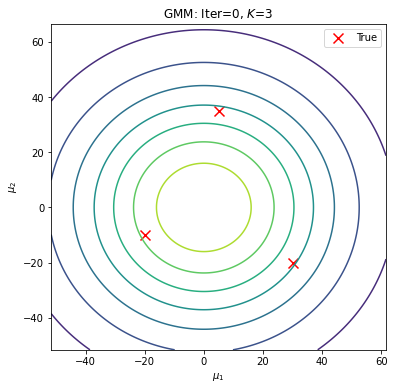

In [6]:
# note12-1と同じなので説明は省略

# muの事前分布のパラメータを指定
beta = 1.0
m_d = np.repeat(0.0, D)

# lambdaの事前分布のパラメータを指定
w_dd = np.identity(D) * 0.0005
nu = D

# piの事前分布のパラメータを指定
alpha_k = np.repeat(2.0, K)

# muの事前分布の標準偏差を計算
sigma_mu_d = np.sqrt(np.linalg.inv(beta * nu * w_dd).diagonal())

# 作図用のx軸のmuの値を作成
mu_0_line = np.linspace(
    np.min(mu_truth_kd[:, 0]) - sigma_mu_d[0], 
    np.max(mu_truth_kd[:, 0]) + sigma_mu_d[0], 
    num=300
)

# 作図用のy軸のmuの値を作成
mu_1_line = np.linspace(
    np.min(mu_truth_kd[:, 1]) - sigma_mu_d[1], 
    np.max(mu_truth_kd[:, 1]) + sigma_mu_d[1], 
    num=300
)

# 作図用の格子状の点を作成
mu_0_grid, mu_1_grid = np.meshgrid(mu_0_line, mu_1_line)

# 作図用のmuの点を作成
mu_point = np.stack([mu_0_grid.flatten(), mu_1_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存
mu_dim = mu_0_grid.shape
print(mu_dim)

# muの事前分布を計算
prior_mu_density = multivariate_normal.pdf(x=mu_point, mean=m_d, cov=np.linalg.inv(beta * nu * w_dd))

# 確認
print(prior_mu_density[:5])

# muの事前分布を作図
plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='True', color='red', s=100, marker='x') # 真の平均
plt.contour(mu_0_grid, mu_1_grid, prior_mu_density.reshape(mu_dim)) # 事前分布
plt.title('GMM: Iter=' + str(0) + ', $K$=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

## 初期値の設定

潜在変数$S$の近似事後分布$q(S)$の期待値$E_{q(S)}[S]$をランダムに生成して初期値とする。また生成した$E_{q(S)}[S]$を用いて、各パラメータ $\mu, \Lambda, \pi$ の近似事後分布 $q(\mu|\Lambda), q(\Lambda), q(\pi)$ のパラメータ $\hat{m}, \hat{\beta}, \hat{\nu}, \hat{W}, \hat{\alpha}$を計算して初期値とする。 

In [7]:
# 潜在変数の近似事後分布の期待値を初期化
E_s_nk = np.random.uniform(low=0.0, high=1.0, size=(N, K)) # 一様乱数の生成関数np.random.uniform()を使って0から1の値を生成し、N行K列の2次元配列を作成してE_s_nkとします。
E_s_nk /= np.sum(E_s_nk, axis=1, keepdims=True) # ランダムに生成した値を、行(データ)ごとの和が1になるように正規化します。(正規化するので乱数の時点で0から1の値である必要はありませんが、確率であることを明示しておきます)

# 確認
print(E_s_nk[:5])
print(np.sum(E_s_nk[:5], axis=1)) # データの和が1になっていることを確認

[[0.05846461 0.25514343 0.68639196]
 [0.05750297 0.55279464 0.38970239]
 [0.37436298 0.24833041 0.37730661]
 [0.24712056 0.33780971 0.41506974]
 [0.11581755 0.51658888 0.36759357]]
[1. 1. 1. 1. 1.]


In [8]:
# 初期値 E_s_nk を用いて、muの近似事後分布(K個の多次元ガウス分布)のパラメータを計算:式(4.114)
beta_hat_k = np.sum(E_s_nk, axis=0) + beta # 精度行列パラメータ
m_hat_kd = (np.dot(E_s_nk.T, x_nd) + beta * m_d) / beta_hat_k.reshape((K, 1)) # 平均パラメータ

# 確認
print(beta_hat_k)
print(m_hat_kd)

[81.99291325 83.75390402 87.25318273]
[[ 6.83222115 10.257831  ]
 [ 5.19821017  8.64794196]
 [ 5.2234187  11.90557632]]


In [9]:
# 初期値 E_s_nk を用いてlambdaの近似後分布(K個のウィシャート分布)のパラメータを計算:式(4.118)
w_hat_kdd = np.zeros((K, D, D))
for k in range(K):
    inv_w_dd = np.dot(E_s_nk[:, k] * x_nd.T, x_nd)
    inv_w_dd += beta * np.dot(m_d.reshape((D, 1)), m_d.reshape((1, D)))
    inv_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape((D, 1)), m_hat_kd[k].reshape((1, D)))
    inv_w_dd += np.linalg.inv(w_dd) 
    w_hat_kdd[k] = np.linalg.inv(inv_w_dd) # 
nu_hat_k = np.sum(E_s_nk, axis=0) + nu # 自由度

# 確認
print(w_hat_kdd)
print(nu_hat_k)

[[[2.58674622e-05 1.46604507e-06]
  [1.46604507e-06 1.23125571e-05]]

 [[2.63223437e-05 1.51672214e-06]
  [1.51672214e-06 1.25366258e-05]]

 [[2.72732248e-05 3.19222581e-07]
  [3.19222581e-07 1.22745812e-05]]]
[82.99291325 84.75390402 88.25318273]


In [10]:
# 初期値 E_s_nk を用いて piの近似事後分布(ディリクレ分布)のパラメータを計算:式(4.58)
alpha_hat_k = np.sum(E_s_nk, axis=0) + alpha_k

# 確認
print(alpha_hat_k)

[82.99291325 84.75390402 88.25318273]


In [11]:
# 得られた超パラメータの初期値を用いて、muの近似事後分布を計算する
posterior_density_kg = np.empty((K, mu_point.shape[0]))
for k in range(K):
    # クラスタkのmuの近似事後分布を計算
    posterior_density_kg[k] = multivariate_normal.pdf( # K個の多次元ガウス分布
        x=mu_point,
        mean=m_hat_kd[k], # 平均
        cov=np.linalg.inv(beta_hat_k[k] * nu_hat_k[k] * w_hat_kdd[k]) # 精度行列
    )

print(posterior_density_kg[:, :5]) # 確認

[[2.17614149e-218 1.33733937e-216 8.01364223e-215 4.68222294e-213
  2.66752222e-211]
 [1.27302887e-219 8.95588468e-218 6.13392104e-216 4.09003776e-214
  2.65506955e-212]
 [1.96236214e-236 1.88652776e-234 1.75980072e-232 1.59286887e-230
  1.39898419e-228]]


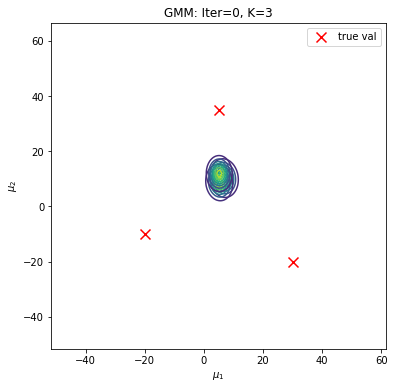

In [12]:
# 初期値によるmuの近似事後分布を作図
plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='true val', 
            color='red', s=100, marker='x') # 真の平均
for k in range(K):
    plt.contour(mu_0_grid, mu_1_grid, posterior_density_kg[k].reshape(mu_dim)) # 近似事後分布

plt.title('GMM: Iter=' + str(0) + ', K=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

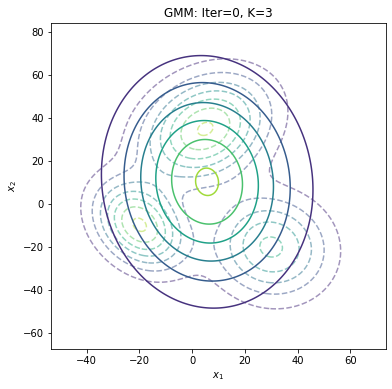

In [13]:
# 初期値から混合分布を計算
init_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(x=x_point, mean=m_hat_kd[k], cov=np.linalg.inv(nu_hat_k[k] * w_hat_kdd[k]))
    
    # K個の分布の加重平均を計算
    init_density += alpha_hat_k[k] / np.sum(alpha_hat_k) * tmp_density

# 初期値による分布を作図
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim)) # 期待値による分布:(等高線)
plt.title('GMM: Iter=' + str(0) + ', K=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [14]:
# 確率が最大のクラスタ番号を抽出
s_n = np.argmax(E_s_nk, axis=1)

# 各データのクラスタとなる確率を抽出
prob_s_n = E_s_nk[np.arange(N), s_n]

# 確認
print(s_n[:5]) # 先頭5個の割り当てを確認
print(prob_s_n[:5]) # 確率を確認

[2 1 2 2 1]
[0.68639196 0.55279464 0.37730661 0.41506974 0.51658888]


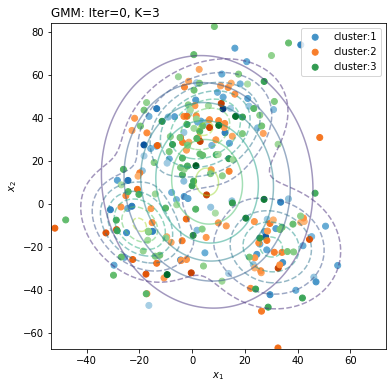

In [15]:
# K個のカラーマップを指定
colormap_list = ['Blues', 'Oranges', 'Greens']

# クラスタの散布図を作成
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim), alpha=0.5) # 期待値による分布
for k in range(K):
    k_idx, = np.where(s_n == k) # クラスタkのデータのインデックス
    cm = plt.get_cmap(colormap_list[k]) # クラスタkのカラーマップを設定
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1), c=[cm(p) for p in prob_s_n[k_idx]]) # 確率によるクラスタ

plt.title('GMM: Iter=' + str(0)+ ', K=' + str(K), loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

# データの生成のときと同様に、各データに割り当てられたクラスタに従って色分けします。
# ただしここでは、そのクラスタとなる確率に従って濃淡を付けることにします。
# plt.get_cmap()によって確率値を色コードに変換したもの(よく分かってない…)を、plt.scatter()の色の引数cに指定します。

## 変分推論

In [16]:
# 試行回数を指定
MaxIter = 100

# 途中計算に用いる項の受け皿を作成
ln_eta_nk = np.zeros((N, K))

# 推移の確認用の受け皿
trace_E_s_ink = [E_s_nk.copy()]
trace_beta_ik = [beta_hat_k.copy()]
trace_m_ikd = [m_hat_kd.copy()]
trace_w_ikdd = [w_hat_kdd.copy()]
trace_nu_ik = [nu_hat_k.copy()]
trace_alpha_ik = [alpha_hat_k.copy()]

# 変分推論
for i in range(MaxIter):
    
    # 潜在変数Sの近似事後分布のパラメータを計算:式(4.109)
    for k in range(K):
        # クラスタkの中間変数を計算:式(4.119-4.122,4.62)
        E_lmd_dd = nu_hat_k[k] * w_hat_kdd[k] # 式(4.119)
        E_ln_det_lmd = np.sum(psi(0.5 * (nu_hat_k[k] - np.arange(D)))) # psi はディガンマ関数
        E_ln_det_lmd += D * np.log(2) + np.log(np.linalg.det(w_hat_kdd[k])) # 式(4.120)
        E_lmd_mu_d1 = np.dot(E_lmd_dd, m_hat_kd[k].reshape((D, 1))) # 式(4.121)
        E_mu_lmd_mu = np.dot(m_hat_kd[k].reshape((1, D)), E_lmd_mu_d1).item() # 式(4.122)前半
        E_mu_lmd_mu += D / beta_hat_k[k] # 式(4.122)つづき
        E_ln_pi = psi(alpha_hat_k[k]) - psi(np.sum(alpha_hat_k)) # 式(4.62)
        
        ln_eta_nk[:, k] = - 0.5 * np.diag(x_nd.dot(E_lmd_dd).dot(x_nd.T)) # N 個全てのデータを一度で処理するために1からNの全ての組み合わせで行い, np.diag()で対角成分(同じデータによる計算結果)のみを取り出します。
        ln_eta_nk[:, k] += np.dot(x_nd, E_lmd_mu_d1).flatten() 
        ln_eta_nk[:, k] += - 0.5 * E_mu_lmd_mu + 0.5 * E_ln_det_lmd + E_ln_pi

    tmp_eta_nk = np.exp(ln_eta_nk)
    eta_nk = (tmp_eta_nk + 1e-7) / np.sum(tmp_eta_nk + 1e-7, axis=1, keepdims=True) # 正規化, 0除算にならないように微小な値 1e-7 を加えている。
    
    # 潜在変数の近似事後分布の期待値を計算:式(4.59)
    E_s_nk = eta_nk.copy()
    
    # この後は初期値の設定と同様にmu, lambda, pi を計算する

    # muの近似事後分布のパラメータを計算:式(4.114)
    beta_hat_k = np.sum(E_s_nk, axis=0) + beta
    m_hat_kd = (np.dot(E_s_nk.T, x_nd) + beta * m_d) / beta_hat_k.reshape((K, 1))
    
    # lambdaの近似事後分布のパラメータを計算:式(4.118)
    w_hat_kdd = np.zeros((K, D, D))
    for k in range(K):
        inv_w_dd = np.dot(E_s_nk[:, k] * x_nd.T, x_nd)
        inv_w_dd += beta * np.dot(m_d.reshape((D, 1)), m_d.reshape((1, D)))
        inv_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape((D, 1)), m_hat_kd[k].reshape((1, D)))
        inv_w_dd += np.linalg.inv(w_dd)
        w_hat_kdd[k] = np.linalg.inv(inv_w_dd)
    nu_hat_k = np.sum(E_s_nk, axis=0) + nu
        
    # piの近似事後分布のパラメータを計算:式(4.58)
    alpha_hat_k = np.sum(E_s_nk, axis=0) + alpha_k
    
    # i回目のパラメータを記録
    trace_E_s_ink.append(E_s_nk.copy())
    trace_beta_ik.append(beta_hat_k.copy())
    trace_m_ikd.append(m_hat_kd.copy())
    trace_w_ikdd.append(w_hat_kdd.copy())
    trace_nu_ik.append(nu_hat_k.copy())
    trace_alpha_ik.append(alpha_hat_k.copy())
    
    # 動作確認
    print(str(i + 1) + ' (' + str(np.round((i + 1) / MaxIter * 100, 1)) + '%)')

1 (1.0%)
2 (2.0%)
3 (3.0%)
4 (4.0%)
5 (5.0%)
6 (6.0%)
7 (7.0%)
8 (8.0%)
9 (9.0%)
10 (10.0%)
11 (11.0%)
12 (12.0%)
13 (13.0%)
14 (14.0%)
15 (15.0%)
16 (16.0%)
17 (17.0%)
18 (18.0%)
19 (19.0%)
20 (20.0%)
21 (21.0%)
22 (22.0%)
23 (23.0%)
24 (24.0%)
25 (25.0%)
26 (26.0%)
27 (27.0%)
28 (28.0%)
29 (29.0%)
30 (30.0%)
31 (31.0%)
32 (32.0%)
33 (33.0%)
34 (34.0%)
35 (35.0%)
36 (36.0%)
37 (37.0%)
38 (38.0%)
39 (39.0%)
40 (40.0%)
41 (41.0%)
42 (42.0%)
43 (43.0%)
44 (44.0%)
45 (45.0%)
46 (46.0%)
47 (47.0%)
48 (48.0%)
49 (49.0%)
50 (50.0%)
51 (51.0%)
52 (52.0%)
53 (53.0%)
54 (54.0%)
55 (55.0%)
56 (56.0%)
57 (57.0%)
58 (58.0%)
59 (59.0%)
60 (60.0%)
61 (61.0%)
62 (62.0%)
63 (63.0%)
64 (64.0%)
65 (65.0%)
66 (66.0%)
67 (67.0%)
68 (68.0%)
69 (69.0%)
70 (70.0%)
71 (71.0%)
72 (72.0%)
73 (73.0%)
74 (74.0%)
75 (75.0%)
76 (76.0%)
77 (77.0%)
78 (78.0%)
79 (79.0%)
80 (80.0%)
81 (81.0%)
82 (82.0%)
83 (83.0%)
84 (84.0%)
85 (85.0%)
86 (86.0%)
87 (87.0%)
88 (88.0%)
89 (89.0%)
90 (90.0%)
91 (91.0%)
92 (92.0%)
93 (93

## 推論結果の確認 (基本的にnote12-1と同じ)

In [17]:
# muの近似事後分布を計算
posterior_density_kg = np.empty((K, mu_point.shape[0]))
for k in range(K):
    # クラスタkのmuの近似事後分布を計算
    posterior_density_kg[k] = multivariate_normal.pdf(
        x=mu_point, 
        mean=m_hat_kd[k], 
        cov=np.linalg.inv(beta_hat_k[k] * nu_hat_k[k] * w_hat_kdd[k]) # 違い
    )

# 確認
print(posterior_density_kg[:, :5])

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [2.62335658e-145 8.55416122e-144 2.69352657e-142 8.19009285e-141
  2.40480638e-139]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]]


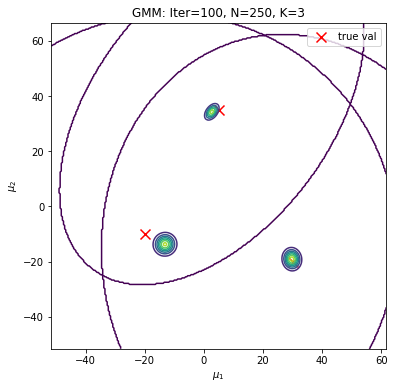

In [18]:
# muの近似事後分布を作図
# muの事後分布を図で確認
# K個のガウス分布がそれぞれ真の平均付近をピークとする分布を推定できていることを確認してください。

plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='true val', 
            color='red', s=100, marker='x') # 真の平均
for k in range(K):
    plt.contour(mu_0_grid, mu_1_grid, posterior_density_kg[k].reshape(mu_dim)) # 事後分布

plt.title('GMM: Iter=' + str(MaxIter) + ', N=' + str(N) + ', K=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

In [19]:
# 最後の試行でサンプルしたパラメータmu_kd, lambda_ddkとpi_kを用いて、混合分布を計算

# K個のカラーマップを指定
colormap_list = ['Blues', 'Oranges', 'Greens']

# 確率が最大のクラスタ番号を抽出
s_n = np.argmax(E_s_nk, axis=1)

# 各データのクラスタとなる確率を抽出
prob_s_n = E_s_nk[np.arange(N), s_n]

# 最後にサンプルしたパラメータによる混合分布を計算
res_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(x=x_point, mean=m_hat_kd[k], cov=np.linalg.inv(nu_hat_k[k] * w_hat_kdd[k]))
    
    # K個の分布の加重平均を計算
    res_density += alpha_hat_k[k] / np.sum(alpha_hat_k) * tmp_density

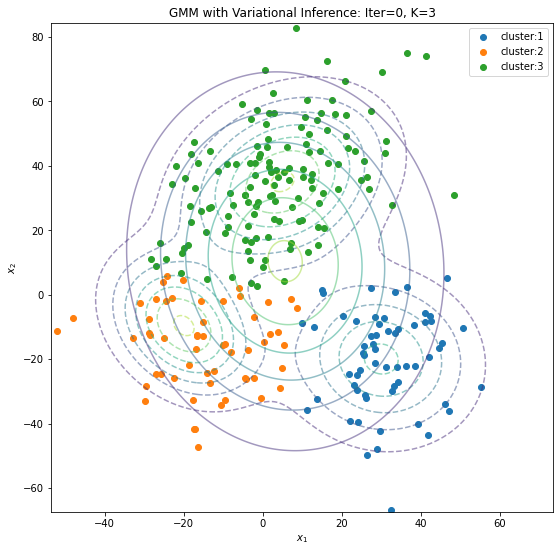

In [20]:
# クラスタの散布図を作成
plt.figure(figsize=(9, 9))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim), alpha=0.5) # 期待値による分布:(塗りつぶし)
for k in range(K):
    k_idx, = np.where(s_n == k) # クラスタkのデータのインデックス
    cm = plt.get_cmap(colormap_list[k]) # クラスタkのカラーマップを設定
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # サンプルしたクラスタ
    #plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1), c=[cm(p) for p in prob_s_n[k_idx]]) # 確率によるクラスタ

plt.title('GMM with Variational Inference: Iter=' + str(0)+ ', K=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

# データの生成のときと同様に、各データに割り当てられたクラスタに従って色分けします。
# ただしここでは、そのクラスタとなる確率に従って濃淡を付けることにします。
# plt.get_cmap()によって確率値を色コードに変換したもの(よく分かってない…)を、plt.scatter()の色の引数cに指定します。

## 超パラメータの推移の確認

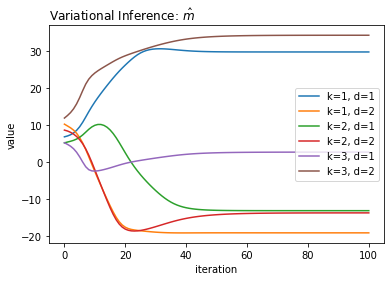

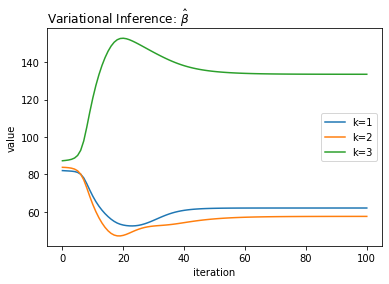

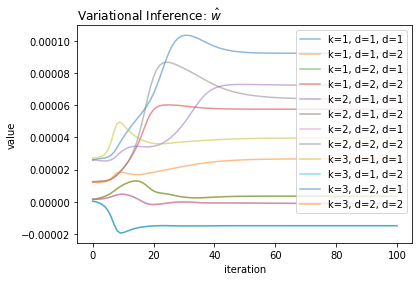

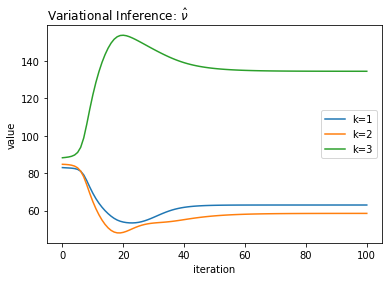

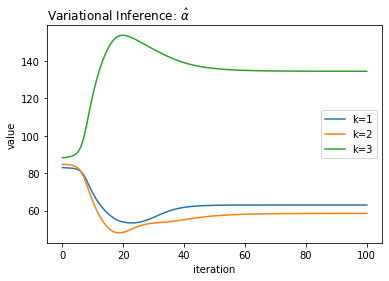

In [21]:
# mの推移を作図
plt.figure()
for k in range(K):
    for d in range(D):
        plt.plot(np.arange(MaxIter+1), np.array(trace_m_ikd)[:, k, d], 
                 label='k=' + str(k + 1) + ', d=' + str(d + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Variational Inference: $\hat{m}$', loc='left')
plt.legend() # 凡例
plt.show()

# betaの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_beta_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Variational Inference: $\hat{\\beta}$', loc='left')
plt.legend() # 凡例
plt.show()

# wの推移を作図
plt.figure()
for k in range(K):
    for d1 in range(D):
        for d2 in range(D):
            plt.plot(np.arange(MaxIter + 1), np.array(trace_w_ikdd)[:, k, d1, d2], 
                     alpha=0.5, label='k=' + str(k + 1) + ', d=' + str(d1 + 1) + ', d''=' + str(d2 + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Variational Inference: $\hat{w}$', loc='left')
plt.legend() # 凡例
plt.show()

# nuの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_nu_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Variational Inference: $\hat{\\nu}$', loc='left')
plt.legend() # 凡例
plt.show()

# alphaの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_alpha_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Variational Inference: $\hat{\\alpha}$', loc='left')
plt.legend() # 凡例
plt.show()